In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
%matplotlib inline

from utils_plotting import plot_with_power_law, display_dict, plot_with_piecewise_power_law

In [2]:
df = pd.read_csv("data/sweep.csv")
df_big = pd.read_csv("data/extrapolation.csv")

opt_params_df = pd.read_csv("data/opt_params_data.csv")
opt_params_df = opt_params_df[opt_params_df["kaplan"] == True] # only use the kaplan-style curve fits

In [3]:
datasets = list(df["data"].unique())
datasets = sorted(datasets)
vals = [c for c in df.columns if "CrossEntropyLoss" in c and "eval" in c]

In [4]:
def get_drop_df(df, data):
    if data == "all":
        return df.copy()
    drop_df = df[df["data"] == data].copy()
    return drop_df

# Downstream accuracy

In [5]:
def plot_acc_curve(ax, df, data, color="blue", test_key="olmo_suite_ce_loss", acc_key="olmo_suite_acc", label=None, add_x=None, ex=None, ey=None, fit=True, piecewise=False):
    drop_df = get_drop_df(df, data)

    x = np.array(drop_df[test_key])
    y = 1 - np.array(drop_df[acc_key])
    
    ex = opt_params_df[(opt_params_df["data"] == data) & (opt_params_df["loss_name"] == test_key)]["E"].values[0]
    
    try:
        if piecewise:
            params = plot_with_piecewise_power_law(ax, x, y, color, label, add_x=add_x, ex=ex, ey=ey, fit=fit)
        else:
            params = plot_with_power_law(ax, x, y, color, label, add_x=add_x, ex=ex, ey=ey, fit=fit)
    except:
        params = plot_with_power_law(ax, x, y, color, label, add_x=add_x, ex=None, ey=None, fit=fit)
        print(f"Failed to fit power law: {data}, {test_key}, {acc_key}")
    return params

In [6]:
test_losses = [c for c in df.columns if "ce_loss" in c and "ctx" not in c and "5shot" not in c and "imbue" not in c and "suite" not in c and "boolq" not in c]
test_losses

['eval/downstream_ce_loss/arc_challenge_test_ce_loss',
 'eval/downstream_ce_loss/arc_easy_test_ce_loss',
 'eval/downstream_ce_loss/hellaswag_test_ce_loss',
 'eval/downstream_ce_loss/mmlu_humanities_test_ce_loss',
 'eval/downstream_ce_loss/mmlu_other_test_ce_loss',
 'eval/downstream_ce_loss/mmlu_social_sciences_test_ce_loss',
 'eval/downstream_ce_loss/mmlu_stem_test_ce_loss',
 'eval/downstream_ce_loss/openbook_qa_test_ce_loss',
 'eval/downstream_ce_loss/piqa_test_ce_loss',
 'eval/downstream_ce_loss/sciq_test_ce_loss',
 'eval/downstream_ce_loss/winogrande_test_ce_loss']

In [7]:
test_accs= [c for c in df.columns if ("len_norm" in c or "acc" in c) and "5shot" not in c and "imbue" not in c and "suite" not in c and "boolq" not in c]
print(len(test_accs))

11


In [8]:
for l, a in zip(test_losses, test_accs):
    print(l, a)

eval/downstream_ce_loss/arc_challenge_test_ce_loss eval/downstream/arc_challenge_test_len_norm
eval/downstream_ce_loss/arc_easy_test_ce_loss eval/downstream/arc_easy_test_acc
eval/downstream_ce_loss/hellaswag_test_ce_loss eval/downstream/hellaswag_test_len_norm
eval/downstream_ce_loss/mmlu_humanities_test_ce_loss eval/downstream/mmlu_humanities_test_len_norm
eval/downstream_ce_loss/mmlu_other_test_ce_loss eval/downstream/mmlu_other_test_len_norm
eval/downstream_ce_loss/mmlu_social_sciences_test_ce_loss eval/downstream/mmlu_social_sciences_test_len_norm
eval/downstream_ce_loss/mmlu_stem_test_ce_loss eval/downstream/mmlu_stem_test_len_norm
eval/downstream_ce_loss/openbook_qa_test_ce_loss eval/downstream/openbook_qa_test_len_norm
eval/downstream_ce_loss/piqa_test_ce_loss eval/downstream/piqa_test_len_norm
eval/downstream_ce_loss/sciq_test_ce_loss eval/downstream/sciq_test_acc
eval/downstream_ce_loss/winogrande_test_ce_loss eval/downstream/winogrande_test_acc


In [9]:
def plot_test_acc(ax, test_key, acc_key, ey=None, fit=True, piecewise=False):

    for j, d in enumerate(datasets):
        big_loss = df_big[df_big["data"] == d][test_key].values[0]
        plot_acc_curve(ax, df, 
                       d, color=sns.color_palette()[j], test_key=test_key, acc_key=acc_key, label=display_dict[d], add_x=big_loss - 1, ey=ey, fit=fit, piecewise=piecewise)
        ax.scatter([big_loss], [1 - df_big[df_big["data"] == d][acc_key].values[0]], color=sns.color_palette()[j], marker="*", s=20, zorder=10)

    ax.set_xlabel("Test Loss")
    ax.set_ylabel("0/1 Classification Error")

    if test_key != "val_loss":
        title = test_key.replace("eval/downstream_ce_loss/", "").replace("_ce_loss", "").replace("_test", "")
        title = title.replace("eval/", "").replace("_val/CrossEntropyLoss", " ").replace("_", " ").title()
    else:
        ax.set_xlabel("Train Loss")
        title = acc_key.replace("eval/", "").replace("downstream/", "").replace("test_len_norm", "").replace("test_acc", "").replace("_", " ").title()
    ax.set_title(title)

/Users/davidbrandfonbrener/code/loss-to-loss-notebooks/utils_plotting.py:60: RuntimeWarning: invalid value encountered in power
  return b * np.power(x - c, a) + d


Failed to fit power law: slimpajama-chunk1, eval/downstream_ce_loss/sciq_test_ce_loss, eval/downstream/sciq_test_acc


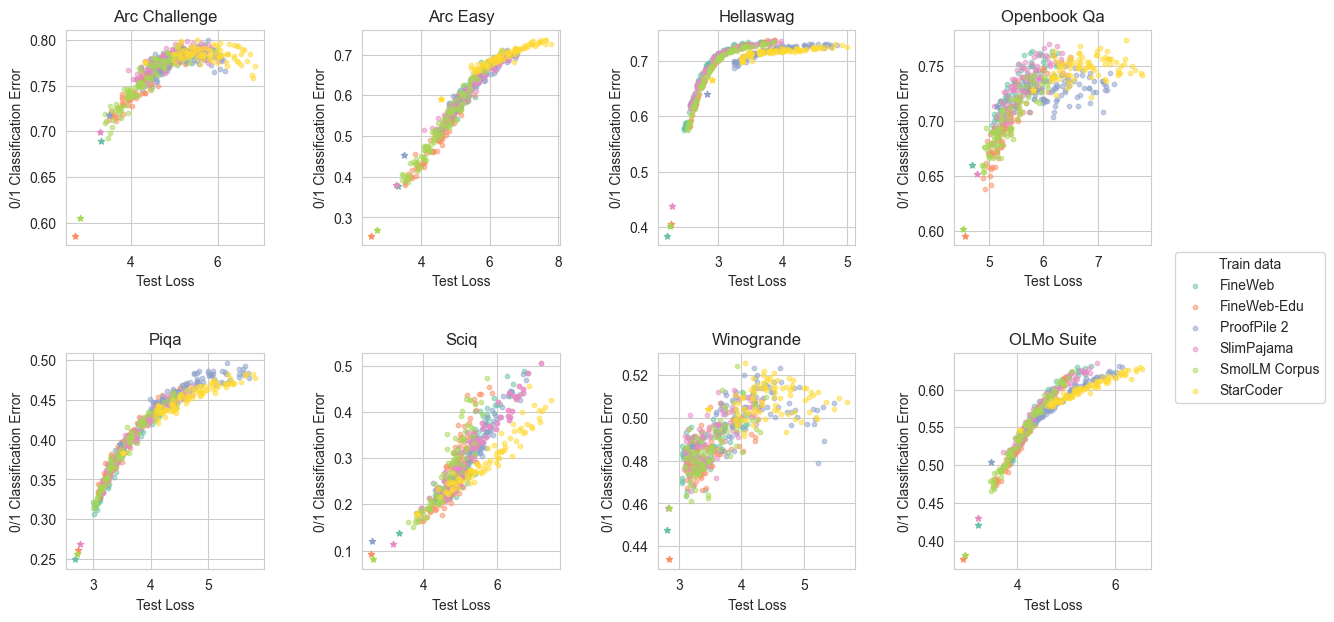

In [16]:
fig, axs = plt.subplots(2, 4, figsize=(14, 7))
fig.subplots_adjust(wspace=0.5)
fig.subplots_adjust(hspace=0.5)
sns.set_palette("Set2", len(datasets))
sns.set_style("whitegrid")

accs = [t for t in test_accs if "mmlu" not in t] + ["olmo_suite_acc"]
losses = [t for t in test_losses if "mmlu" not in t] + ["olmo_suite_ce_loss"]

for i, ax in enumerate(axs.flatten()):
    plot_test_acc(ax, losses[i], accs[i], fit=False)
    if i == 7:
        ax.set_title("OLMo Suite")


ax.legend(loc='upper center', bbox_to_anchor=(1.5, 1.5), ncol=1, title="Train data")

plt.savefig("figures/olmo_acc_test.pdf", bbox_inches="tight")

plt.show()

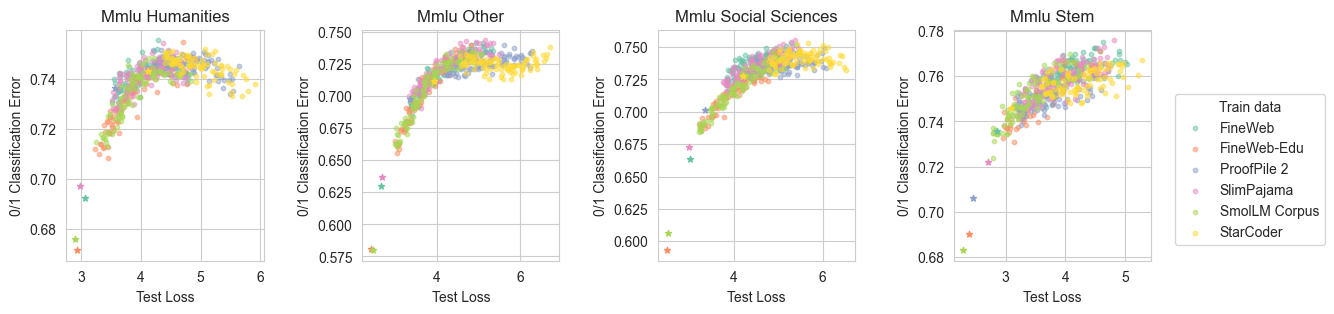

In [11]:
fig, axs = plt.subplots(1, 4, figsize=(14, 3))
fig.subplots_adjust(wspace=0.5)
fig.subplots_adjust(hspace=0.5)
sns.set_palette("Set2", len(datasets))
sns.set_style("whitegrid")

accs = [t for t in test_accs if "mmlu" in t] 
losses = [t for t in test_losses if "mmlu" in t]

for i, ax in enumerate(axs.flatten()):
    plot_test_acc(ax, losses[i], accs[i], fit=False)


ax.legend(loc='upper center', bbox_to_anchor=(1.5, 0.75), ncol=1, title="Train data")

plt.savefig("figures/mmlu_acc_test.pdf", bbox_inches="tight")

plt.show()

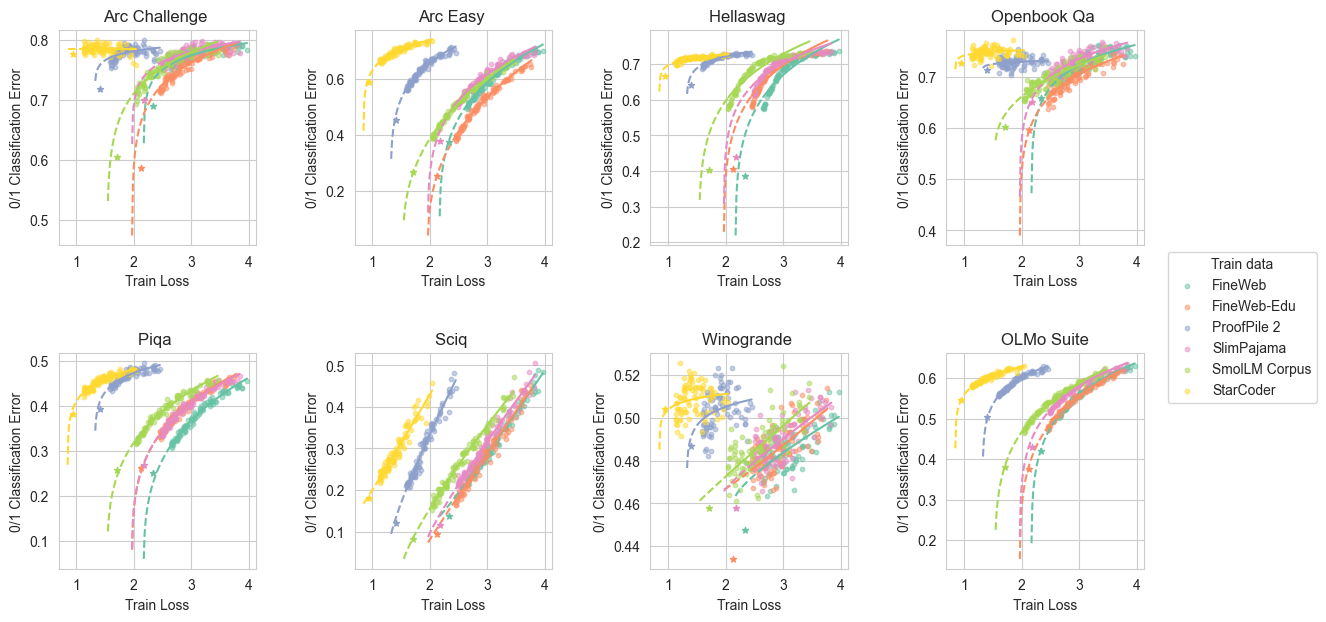

In [12]:
fig, axs = plt.subplots(2, 4, figsize=(14, 7))
fig.subplots_adjust(wspace=0.5)
fig.subplots_adjust(hspace=0.5)
sns.set_palette("Set2", len(datasets))
sns.set_style("whitegrid")

accs = [t for t in test_accs if "mmlu" not in t] + ["olmo_suite_acc"]

for i, ax in enumerate(axs.flatten()):
    plot_test_acc(ax, "val_loss", accs[i])
    if i == 7:
        ax.set_title("OLMo Suite")


ax.legend(loc='upper center', bbox_to_anchor=(1.5, 1.5), ncol=1, title="Train data")

plt.savefig("figures/olmo_acc.pdf", bbox_inches="tight")

plt.show()

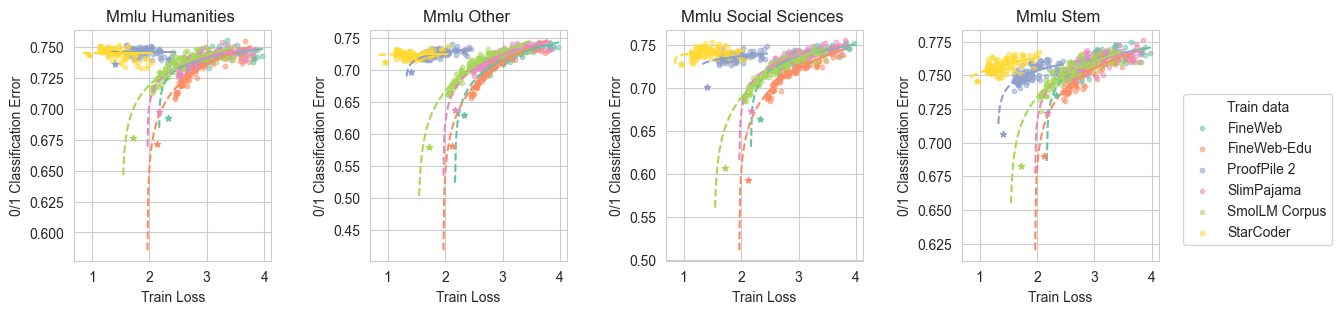

In [13]:
fig, axs = plt.subplots(1, 4, figsize=(14, 3))
fig.subplots_adjust(wspace=0.5)
fig.subplots_adjust(hspace=0.5)
sns.set_palette("Set2", len(datasets))
sns.set_style("whitegrid")

accs = [t for t in test_accs if "mmlu" in t] 

for i, ax in enumerate(axs.flatten()):
    plot_test_acc(ax, "val_loss", accs[i])
    ax.set_xlabel("Train Loss")
    if i == 7:
        ax.set_title("OLMo Suite")


ax.legend(loc='upper center', bbox_to_anchor=(1.5, 0.75), ncol=1, title="Train data")

plt.savefig("figures/mmlu_acc.pdf", bbox_inches="tight")

plt.show()

/Users/davidbrandfonbrener/code/loss-to-loss-notebooks/utils_plotting.py:182: RuntimeWarning: invalid value encountered in power
  return soft_min(e, b * np.power(x - c, a) + d)


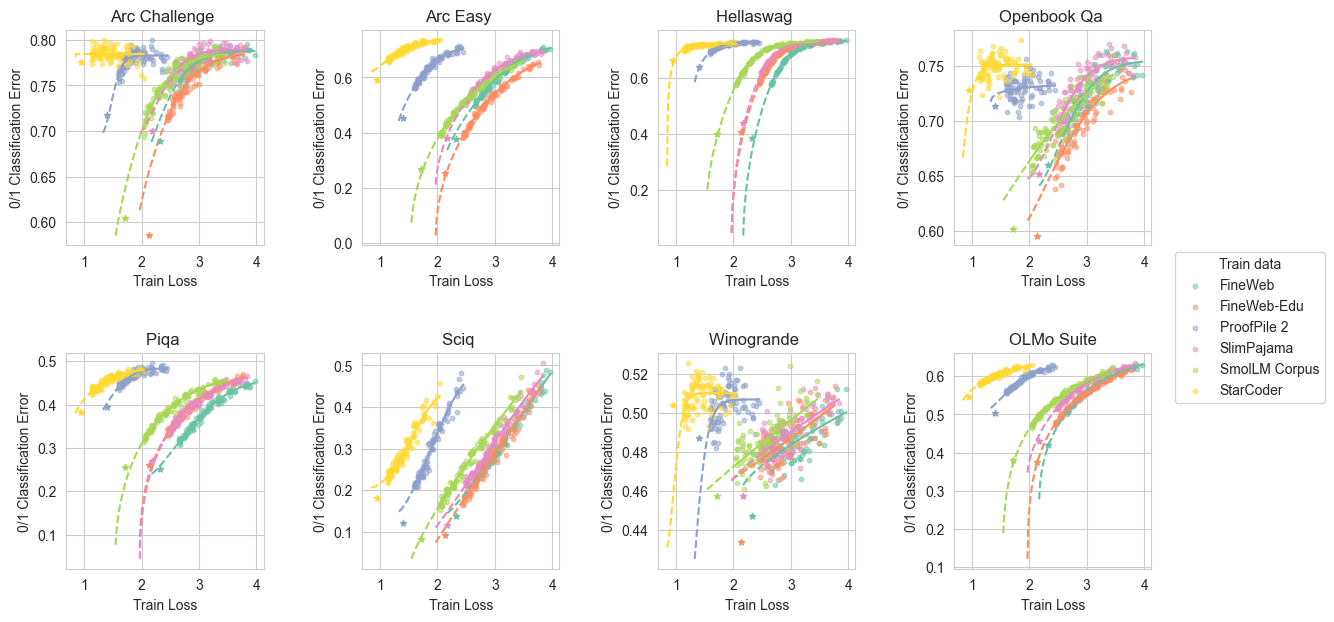

In [14]:
fig, axs = plt.subplots(2, 4, figsize=(14, 7))
fig.subplots_adjust(wspace=0.5)
fig.subplots_adjust(hspace=0.5)
sns.set_palette("Set2", len(datasets))
sns.set_style("whitegrid")

accs = [t for t in test_accs if "mmlu" not in t] + ["olmo_suite_acc"]

for i, ax in enumerate(axs.flatten()):
    plot_test_acc(ax, "val_loss", accs[i], piecewise=True)
    if i == 7:
        ax.set_title("OLMo Suite")


ax.legend(loc='upper center', bbox_to_anchor=(1.5, 1.5), ncol=1, title="Train data")

plt.savefig("figures/olmo_acc_piecewise.pdf", bbox_inches="tight")

plt.show()

/Users/davidbrandfonbrener/code/loss-to-loss-notebooks/utils_plotting.py:182: RuntimeWarning: invalid value encountered in power
  return soft_min(e, b * np.power(x - c, a) + d)


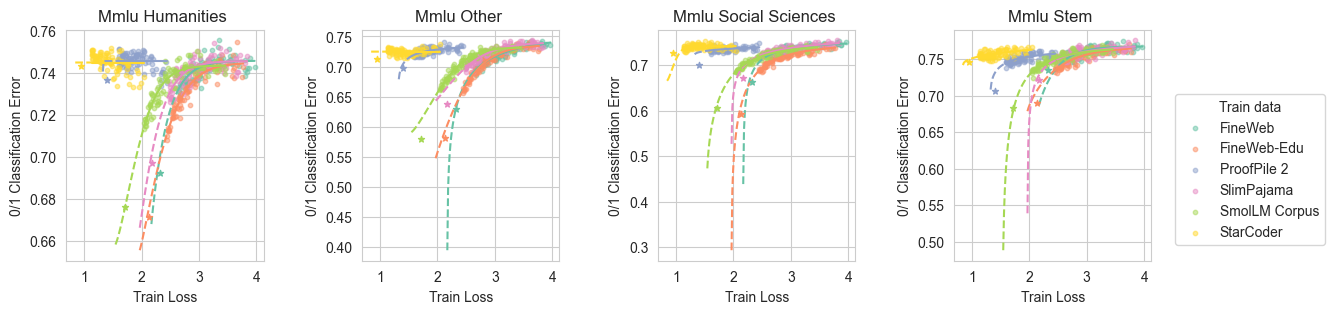

In [15]:
fig, axs = plt.subplots(1, 4, figsize=(14, 3))
fig.subplots_adjust(wspace=0.5)
fig.subplots_adjust(hspace=0.5)
sns.set_palette("Set2", len(datasets))
sns.set_style("whitegrid")

accs = [t for t in test_accs if "mmlu" in t] 

for i, ax in enumerate(axs.flatten()):
    plot_test_acc(ax, "val_loss", accs[i], piecewise=True)
    ax.set_xlabel("Train Loss")
    if i == 7:
        ax.set_title("OLMo Suite")


ax.legend(loc='upper center', bbox_to_anchor=(1.5, 0.75), ncol=1, title="Train data")

plt.savefig("figures/mmlu_acc_piecewise.pdf", bbox_inches="tight")

plt.show()